# Домашнее задание 1. Autoencoders & Frechet Inception Distance


В этом домашнем задании вам предлагается вспомнить то, что происходило на семинарах 1-2, написать свой автоэнкодер на CIFAR10 и использовать эмбеддинги от этого автоэнкодера чтобы посчитать Frechet Inception Distance (FID) между разными классами в CIFAR10

In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from sklearn.ensemble import GradientBoostingClassifier
from collections import defaultdict
import seaborn as sns

Будем использовать torchvision для работы с данными.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x * 2) - 1
])

In [3]:
train_dataset = datasets.CIFAR10(
    './cifar',
    train=True,
    transform=transform,
    download=True)
val_dataset = datasets.CIFAR10(
    './cifar',
    train=False,
    transform=transform,
    download=True)
len(train_dataset), len(val_dataset)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

Раз мы используем нормализацию картинок, то чтобы их нарисовать - надо их обратно разнормализировать

In [4]:
def denormalize_image(image):
    return (image + 1) / 2

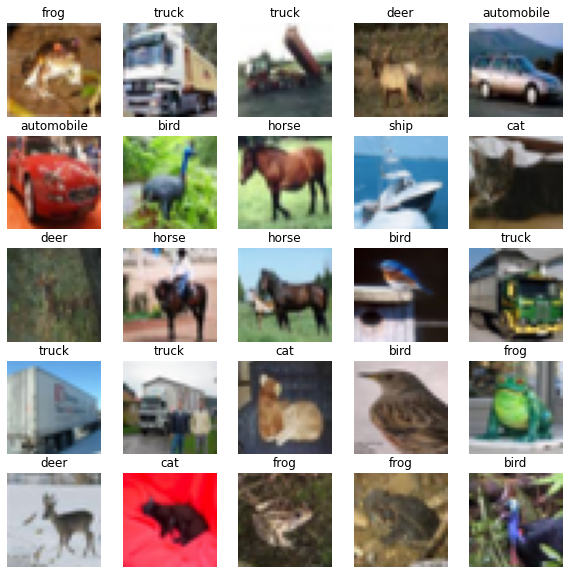

In [5]:
text_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 10))
for index, (image, label) in enumerate(train_dataset):
    plt.subplot(5, 5, index + 1)
    plt.imshow(denormalize_image(image.permute(1, 2, 0)))
    plt.axis('off')
    plt.title(text_labels[label])
    if index == 24: break
plt.show()

Размерность картинок: 3 канала 32х32 пикселя

In [6]:
image.shape

torch.Size([3, 32, 32])

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
len(train_loader), len(val_loader)

(1563, 10000)

### Задание 1. Обучить AE (3 балла)

Постройте свой AE, можете использовать любые блоки которые вам кажутся необходимыми.

<img src='https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png' width=500>

Напишите классы Encoder и Decoder

хинт: вам пригодятся nn.AvgPool2d/nn.MaxPool2d/Conv2d в энкодере и nn.Upsample/nn.ConvTranspose2d в декодере

In [8]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, only_conv=False):
        super().__init__()
        
        self.down = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        ]
        
        if not only_conv:
            self.down += [
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
            ]
            
        self.down = nn.Sequential(*self.down)
        
    def forward(self, x):
        return self.down(x)
        

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.downnet = [
            DownBlock(3, 16, 2),
            DownBlock(16, 32, 2),
            DownBlock(32, 64, 2, only_conv=True),
        ]

        self.downnet = nn.Sequential(*self.downnet)

    def forward(self, x):
        x = self.downnet(x)
        
        return x

In [9]:
encoder = Encoder()
noise = torch.rand(1, 3, 32, 32) - 1
assert encoder(noise).view(-1).shape[0] < 1*3*32*32

In [113]:
encoder(noise).shape

torch.Size([1, 32, 4, 4])

In [10]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, only_conv=False):
        super().__init__()
        
        if stride > 1:
            self.up = [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, output_padding=1)
            ]
        else:
            self.up = [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
            ]
        
        if not only_conv:
            self.up += [
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
            ]
            
        self.up = nn.Sequential(*self.up)
        
    def forward(self, x):
        return self.up(x)

    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.upnet = [
            nn.ReLU(),
            UpBlock(64, 32, 2),
            UpBlock(32, 16, 2),
            UpBlock(16, 3, 2, only_conv=True),
        ]
        
        self.upnet = nn.Sequential(*self.upnet)

    def forward(self, x):
        x = self.upnet(x)

        return torch.tanh(x)


In [11]:
decoder = Decoder()
noise = torch.rand(1, 3, 32, 32)
emb = encoder(noise)
assert decoder(emb).shape == (1, 3, 32, 32)

Посчитаем скор классификации картинок по эмбеддингам необученного энкодора, и в конце сравним с обученным. Для ускорения расчета, мы используем только часть трейна.

In [12]:
def classification_score(encoder, _train_dataset, val_dataset, device):
    encoder.eval()
    torch.manual_seed(0)
    train_dataset = Subset(_train_dataset, torch.randperm(len(_train_dataset))[:5000])
    X_train = []
    y_train = []
    for image, label in tqdm(train_dataset):
        image = image.to(device)
        with torch.no_grad():
            emb = encoder(image[None, ...])
        X_train.append(emb.cpu().numpy().reshape(-1))
        y_train.append(label)
    X_train = np.stack(X_train)
    y_train = np.stack(y_train)
    clf = GradientBoostingClassifier(n_estimators=10, max_depth=5, verbose=1, random_state=0)
    clf.fit(X_train, y_train)
    X_val = []
    y_val = []
    for image, label in tqdm(val_dataset):
        image = image.to(device)
        with torch.no_grad():
            emb = encoder(image[None, ...])
        X_val.append(emb.cpu().numpy().reshape(-1))
        y_val.append(label)
    X_val = np.stack(X_val)
    y_val = np.stack(y_val)
    return clf.score(X_val, y_val)

In [13]:
classification_score(Encoder(), train_dataset, val_dataset, 'cpu')

  0%|          | 0/5000 [00:00<?, ?it/s]

      Iter       Train Loss   Remaining Time 
         1           2.1103            3.19m
         2           1.9609            2.83m
         3           1.8422            2.45m
         4           1.7322            2.09m
         5           1.6375            1.74m
         6           1.5571            1.39m
         7           1.4869            1.04m
         8           1.4185           41.62s
         9           1.3600           20.80s
        10           1.3041            0.00s


  0%|          | 0/10000 [00:00<?, ?it/s]

0.3285

In [14]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [15]:
encoder.to(device)
decoder.to(device);

In [16]:
params = list(encoder.parameters()) + list(decoder.parameters())
optim = torch.optim.AdamW(params)

Напишите функцию train, которая обучает энкодер и декодер на всем трейн сете, возвращает среднюю MSE ошибку

In [17]:
    def train(loader, optim, encoder, decoder, device):
        encoder.train()
        decoder.train()
        losses = []
        for image, _ in tqdm(loader, leave=False):
            image = image.to(device)

            enc_image = encoder(image)
            rec_image = decoder(enc_image)

            optim.zero_grad()

            loss = nn.functional.mse_loss(rec_image, image)
            loss.backward()
            optim.step()

            losses.append(loss.item())

        return sum(losses) / len(losses)

In [18]:
temp_dataloader = DataLoader(Subset(train_dataset, [0]), batch_size=1)
loss = train(temp_dataloader, optim, encoder, decoder, device)
assert type(loss) == float
assert 0 < loss < 1
loss

  0%|          | 0/1 [00:00<?, ?it/s]

0.5215088129043579

Напишите функцию eval, которая возвращает среднюю MSE ошибку по всему валидационному сету

хинт: не забывайте отключать расчет градиентов

In [19]:
def eval(loader, encoder, decoder, device):
    encoder.eval()
    decoder.eval()
    losses = []
    with torch.no_grad():
        for image, _ in tqdm(loader, leave=False):
            image = image.to(device)

            enc_image = encoder(image)
            rec_image = decoder(enc_image)

            loss = nn.functional.mse_loss(rec_image, image)
            losses.append(loss.item())
    return sum(losses) / len(losses)

In [20]:
temp_dataloader = DataLoader(Subset(train_dataset, [0]), batch_size=1)
loss = eval(temp_dataloader, encoder, decoder, device)
assert type(loss) == float
assert 0 < loss < 1
loss

  0%|          | 0/1 [00:00<?, ?it/s]

0.28704699873924255

Функция full_train возвращает обученный энкодер и декодер. Чтобы пройти ограничения по времени, обучите модель, а затем добавьте загрузку предобученных весов в самое начало функции. Можете использовать шаблон для загрузки весов из Google Drive.

In [33]:
import gdown

def full_train(device, train_loader, val_loader):
    url = 'https://drive.google.com/file/d/1lPIa2WuYdkgWvtqZiIMQf-MtcJqcKsPl/view?usp=sharing'
    gdown.download(url, 'encoder.weights', fuzzy=True)
    url = 'https://drive.google.com/file/d/1WCm6owFpAIM6brmcXtfDst7mxzF8GY3m/view?usp=sharing'
    gdown.download(url, 'decoder.weights', fuzzy=True)
    encoder = Encoder().to(device)
    decoder = Decoder().to(device)
    encoder.load_state_dict(torch.load('encoder.weights', map_location=device))
    decoder.load_state_dict(torch.load('decoder.weights', map_location=device))
    
    return encoder, decoder

    
    encoder = Encoder().to(device)
    decoder = Decoder().to(device)
    params = list(encoder.parameters()) + list(decoder.parameters())
    optim = torch.optim.AdamW(params)
    train_loss = []
    val_loss = []
    n_epochs = 30
    for e in trange(n_epochs):
        e_train_loss = train(train_loader, optim, encoder, decoder, device)
        train_loss.append(e_train_loss)
        e_val_loss = eval(val_loader, encoder, decoder, device)
        val_loss.append(e_val_loss)
        print(f'Epoch: {e+1}/{n_epochs}')
        print(f'Train MSE loss: {e_train_loss:.4f}')
        print(f'Validation MSE loss: {e_val_loss:.4f}')
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='val')
    plt.legend()
    plt.title('MSE Loss')
    plt.show()
    return encoder, decoder

In [34]:
encoder, decoder = full_train(device, train_loader, val_loader)

Downloading...
From: https://drive.google.com/uc?id=1lPIa2WuYdkgWvtqZiIMQf-MtcJqcKsPl
To: E:\programming\hse\GM\encoder.weights
100%|███████████████████████████████████████████████████████████████████████████████| 100k/100k [00:00<00:00, 1.93MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WCm6owFpAIM6brmcXtfDst7mxzF8GY3m
To: E:\programming\hse\GM\decoder.weights
100%|█████████████████████████████████████████████████████████████████████████████| 99.8k/99.8k [00:00<00:00, 2.00MB/s]


In [23]:
score = classification_score(encoder, train_dataset, val_dataset, device)
assert score > 0.34

  0%|          | 0/5000 [00:00<?, ?it/s]

      Iter       Train Loss   Remaining Time 
         1           2.0775            3.10m
         2           1.9072            2.75m
         3           1.7772            2.41m
         4           1.6681            2.07m
         5           1.5707            1.72m
         6           1.4873            1.38m
         7           1.4074            1.03m
         8           1.3385           41.39s
         9           1.2782           20.70s
        10           1.2230            0.00s


  0%|          | 0/10000 [00:00<?, ?it/s]

In [133]:
score

0.3465

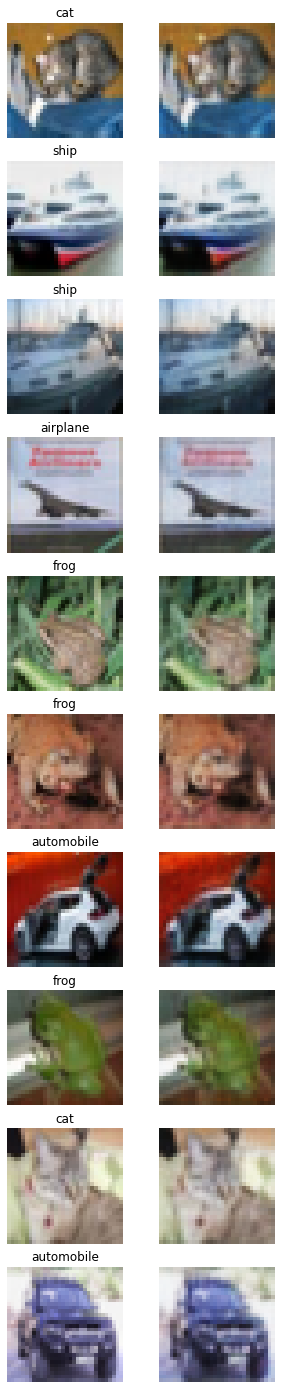

In [24]:
encoder.eval()
decoder.eval()
plt.figure(figsize=(5, 25))
for index, (image, label) in enumerate(val_loader):
    plt.subplot(10, 2, index*2+1)
    plt.imshow(denormalize_image(image)[0].permute(1, 2, 0))
    plt.axis('off')
    plt.title(text_labels[label])
    plt.subplot(10, 2, index*2+2)
    image = image.to(device)
    with torch.no_grad():
        emb = encoder(image)
        rec = decoder(emb).cpu()
    plt.imshow(denormalize_image(rec)[0].permute(1, 2, 0))
    plt.axis('off')
    if index == 9: break

### Задание 2. FID дистанция между классами CIFAR10 (3 балла)

В этой части хочется чтобы вы, используя bottleneck репрезентации от AE обученного в прошлой части посчитали FID дистанцию между различными классами CIFAR10 на **валидационной** выборке

За копию кода из сети будем снимать баллы

Напишите функцию get_representations, которая возвращает defaultdict, где ключ — это номер класса, значение — это список эмбеддингов, полученных из энкодера.

In [25]:
def get_representations(dataloader, encoder, device):
    representations = defaultdict(list)
    
    for image, labels in tqdm(dataloader, leave=False):
        image = image.to(device)

        enc_image = encoder(image)
        
        for i in range(len(image)):
            representations[labels[i].item()].append(enc_image[i].detach().cpu())
            
    return representations

In [26]:
representations = get_representations(val_loader, encoder, device)
assert len(representations) == 10
assert len(representations[0]) == 1000
assert type(representations[0][0]) == torch.Tensor

  0%|          | 0/10000 [00:00<?, ?it/s]

Напишите функцию расчета FID
$$\text{FID}=\left\|\mu_{r}-\mu_{g}\right\|^{2}+T_{r}\left(\Sigma_{r}+\Sigma_{g}-2\left(\Sigma_{r} \Sigma_{g}\right)^{1 / 2}\right)$$

In [27]:
from scipy.linalg import sqrtm

def calculate_fid(repr1, repr2):
    repr1 = repr1.reshape(repr1.shape[0], -1)
    repr2 = repr2.reshape(repr2.shape[0], -1)
    
    mu1 = np.mean(repr1, axis=0)
    mu2 = np.mean(repr2, axis=0)
    
    sigma1 = np.cov(repr1, rowvar=False)
    sigma2 = np.cov(repr2, rowvar=False)
    
    return ((mu1 - mu2)**2).sum() + np.trace(sigma1 + sigma2 - 2 * sqrtm(sigma1 @ sigma2).real) 


In [28]:
heatmap = np.zeros((10, 10))
for label_from in trange(10):
    for label_to in range(10):
        fid = calculate_fid(
            torch.stack(representations[label_from], dim=0).cpu().numpy(),
            torch.stack(representations[label_to], dim=0).cpu().numpy()
        )
        heatmap[label_from, label_to] = fid
assert heatmap.shape == (10, 10)
assert np.all(heatmap + 1e-5 > 0)
airplane_ship = heatmap[0, 8]
airplane_frog = heatmap[0, 6]
truck_automobile = heatmap[9, 1]
truck_dog = heatmap[9, 5]
assert airplane_ship < airplane_frog
assert truck_automobile < truck_dog

  0%|          | 0/10 [00:00<?, ?it/s]

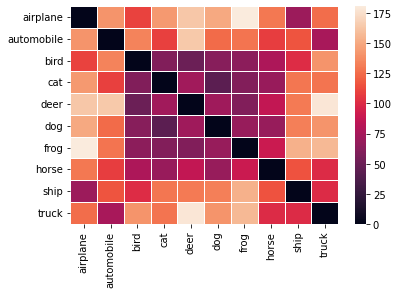

In [29]:
sns.heatmap(
    heatmap, 
    linewidth=0.5, 
    xticklabels=text_labels, 
    yticklabels=text_labels
)
plt.show()

In [30]:
torch.save(encoder.state_dict(), 'enc')
torch.save(decoder.state_dict(), 'dec')